In [1]:
import numpy as np
import pandas as pd

from molloader import *
from ML_utils import *

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, KFold

In [2]:
def drop_duplicates(df):
    df = df.drop_duplicates(subset="compound", keep="first")
    print("Number of molecules", df.shape[0])
    return df

In [3]:
def get_all_elements(df):
      return np.unique(np.hstack(np.array(df.species)))

In [4]:
class VoxelNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # (N, C, D, H, W)
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, 3, padding=0, stride=1),
            nn.SELU(),
            nn.MaxPool3d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU(),
            nn.MaxPool3d(2))
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU())
        
        self.regressor = nn.Sequential(nn.Flatten(),
                                        nn.Linear(1024, 32),
                                        nn.SELU(),
                                        nn.Linear(32, 8),
                                        nn.SELU(),
                                        nn.Linear(8, 1))
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.regressor(x)
        return x

In [5]:
data_name = "all_3_species_oxides"
fig_folder = "plots_SELU/"

In [6]:
df = pd.read_pickle(f"data/{data_name}.pkl")
df = drop_duplicates(df)
df

Number of molecules 5456


,auid,aurl,compound,composition,species,natoms,spacegroup,pearson_symbol,geometry,positions_fractional,positions_cartesian,enthalpy_atom,enthalpy_formation_atom
0,aflow:b281fdee92d2d2b2,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOOs_pv/...,Ag1O3Os1,"[1, 3, 1]","[Ag, O, Os]",5,221,cP5,"[3.9184369, 3.9184369, 3.9184369, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.95922, 1.95922], [1....",-5.34058,0.427456
2,aflow:0783c5b47a9319f1,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOP/T000...,Ag1O3P1,"[1, 3, 1]","[Ag, O, P]",5,221,cP5,"[3.57933, 3.57933, 3.57933, 90.0, 90.0, 90.0]","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [-0.0, 1.78966, 1.78966], [1...",-4.90593,-0.316921
4,aflow:701ef4b4f46ea7cd,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPb_d/T...,Ag1O3Pb1,"[1, 3, 1]","[Ag, O, Pb]",5,221,cP5,"[4.2942064, 4.2942064, 4.2942064, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 2.1471, 2.1471], [2.14...",-3.97006,0.295059
6,aflow:a7a77ee138e41496,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPd_pv/...,Ag1O3Pd1,"[1, 3, 1]","[Ag, O, Pd]",5,221,cP5,"[3.9991958, 3.9991958, 3.9991958, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.9996, 1.9996], [1.99...",-3.40735,1.19322
8,aflow:5fee8d04571dae6f,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgOPt/T00...,Ag1O3Pt1,"[1, 3, 1]","[Ag, O, Pt]",5,221,cP5,"[3.9809833, 3.9809833, 3.9809833, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, ...","[[0.0, 0.0, 0.0], [0.0, 1.99049, 1.99049], [1....",-3.71702,1.01812
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11883,aflow:aaf7c3d68a5e61eb,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/BCT/O4Tm1...,O8Tm2V2,"[8, 2, 2]","[O, Tm, V]",12,141,tI24,"[5.926409, 5.926409, 5.926409, 106.3931, 106.3...","[[0.67778748, 0.49098905, 0.81320157], [0.6777...","[[2.22395, 3.55034, 1.11949], [1.3264, 0.0, 4....",-8.21900,None
11884,aflow:dd0ff61000b8e748,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/BCT/O4V1Y...,O8V2Y2,"[8, 2, 2]","[O, V, Y]",12,141,tI24,"[6.019827, 6.019827, 6.019827, 106.199, 106.19...","[[0.86631316, 0.80059798, 0.065715186], [0.234...","[[0.0, 0.47505, 5.09108], [3.61447, -0.47505, ...",-8.44561,None
11895,aflow:b9e0c6c998904bf1,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/BCT/O4V1Y...,O8V2Yb2,"[8, 2, 2]","[O, V, Yb]",12,141,tI24,"[5.961606, 5.961606, 5.961606, 106.3982, 106.3...","[[0.32709444, 0.51588908, 0.18879464], [0.3270...","[[1.34845, -0.0, 2.0722], [2.22276, 3.57122, -...",-7.03838,None
11898,aflow:36a24bb71d323a35,aflowlib.duke.edu:AFLOWDATA/ICSD_WEB/BCT/O4V2Z...,O8V4Zn2,"[8, 4, 2]","[O, V, Zn]",14,141,tI28,"[5.976299, 5.976299, 5.976299, 120.0156, 120.0...","[[0.25815325, 0.24220713, 0.98405389], [0.2581...","[[2.89217, 2.98745, -2.04451], [3.08272, 0.0, ...",-7.07798,None


In [7]:
elements = get_all_elements(df)
nchannel = len(elements)
nchannel, elements

(81,
 array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
        'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F',
        'Fe', 'Ga', 'Gd', 'Ge', 'H', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir',
        'K', 'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd',
        'Ni', 'O', 'Os', 'P', 'Pa', 'Pb', 'Pd', 'Pr', 'Pt', 'Pu', 'Rb',
        'Re', 'Rh', 'Ru', 'S', 'Sb', 'Sc', 'Se', 'Si', 'Sn', 'Sr', 'Ta',
        'Tb', 'Tc', 'Te', 'Th', 'Ti', 'Tl', 'Tm', 'U', 'V', 'W', 'Xe', 'Y',
        'Yb', 'Zn', 'Zr'], dtype='<U2'))

In [8]:
net = VoxelNet(nchannel)
count_parameters(net)

81937

## Cartesian

(4910, 13) (546, 13)
Initialised MolLoader with 4910 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=81, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 546 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=81, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 5.272721290588379 val loss 2.5177345275878906
Epoch 1: train loss 1.6270900964736938 val loss 0.7923768162727356
Epoch 2: train loss 0.573178768157959 val loss 0.5763155817985535
Epoch 3: train loss 0.4787319302558899 val loss 0.49947959184646606
Epoch 4: train loss 0.4925091564655304 val loss 0.4892086386680603
Epoch 5: train loss 0.447494238615036 val loss 0.5895156860351562
Epoch 6: train loss 0.4295744299888611 val loss 0.44974765181541443
Epoch 7: train loss 0.41408467292785645 val loss 0.4326372742652893
Epoch 8: train loss 0.38894522190093994 val loss 0.5508313775062561
Epoch 9: train loss 0.4237104654312134 val loss 0.4266239404678345
Epoch 10: train loss 0.3760

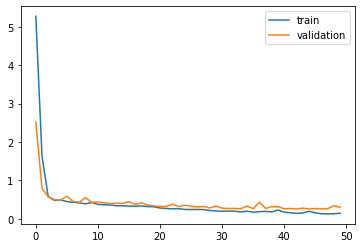

In [9]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()


seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode="cartesian")

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode="cartesian")

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)

### Train Plots

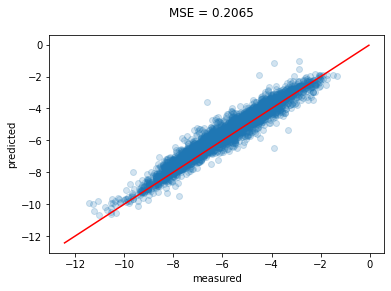

In [10]:
# 0.2065 50 epoch
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)
plt.show()

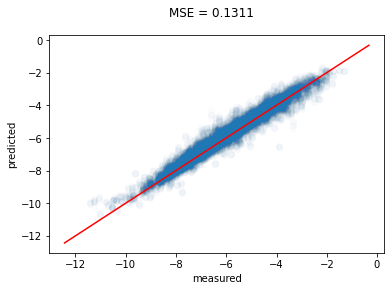

In [11]:
# 0.1311 50 epoch
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats, alpha=0.01)
plt.savefig(fig_folder + data_name + "_cartesian_train.pdf")

### Test Plots

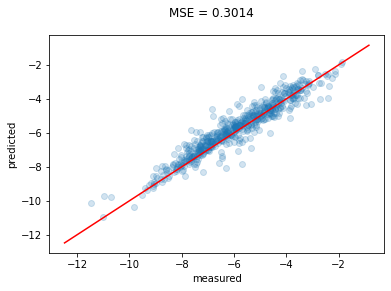

In [12]:
# 0.3014 50 epoch
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)
plt.show()

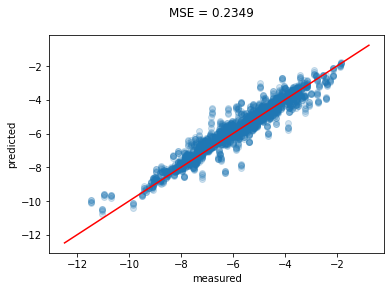

In [13]:
# 0.2349 50 epoch
# rotations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats)
plt.savefig(fig_folder + data_name + "_cartesian_test.pdf")

Initialised MolLoader with 546 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=81, mode=spherical, shuffle=False, rotate=False, device=cuda


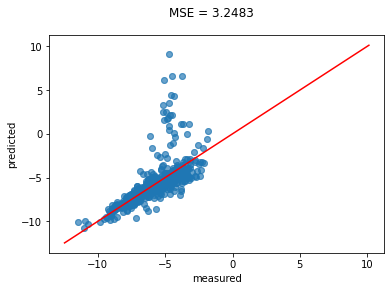

In [14]:
# rotations
seed_everything()
ml_wrong_mode_pred = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode="spherical")
ys, y_hats = predict_epochs(net, ml_wrong_mode_pred, epochs=5)
plot_predictions(ys, y_hats)
plt.show()

## Spherical

(4910, 13) (546, 13)
Initialised MolLoader with 4910 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=81, mode=spherical, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 546 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=81, mode=spherical, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 5.171070575714111 val loss 2.2031257152557373
Epoch 1: train loss 1.053733229637146 val loss 0.6918962597846985
Epoch 2: train loss 0.5677644610404968 val loss 0.5322962999343872
Epoch 3: train loss 0.5187839865684509 val loss 0.5182239413261414
Epoch 4: train loss 0.5010004043579102 val loss 0.4838829040527344
Epoch 5: train loss 0.4730702340602875 val loss 0.5427387952804565
Epoch 6: train loss 0.4695684313774109 val loss 0.44620221853256226
Epoch 7: train loss 0.44029518961906433 val loss 0.46835723519325256
Epoch 8: train loss 0.4241635501384735 val loss 0.4554938077926636
Epoch 9: train loss 0.44040173292160034 val loss 0.5099843740463257
Epoch 10: train loss 0.425

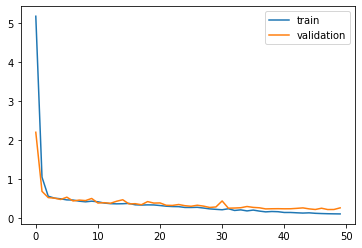

In [15]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()


seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode="spherical")

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode="spherical")

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)

### Train Plots

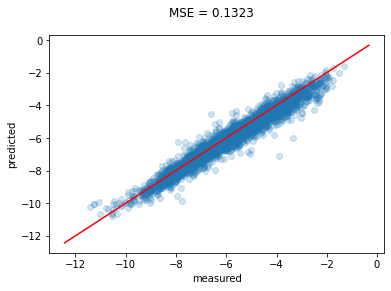

In [16]:
# 0.1323 50 epoch
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)
plt.show()

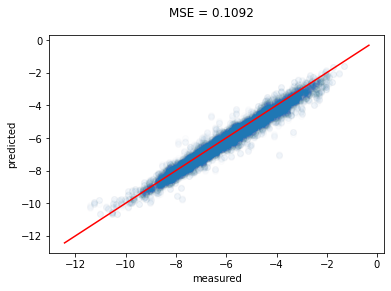

In [17]:
# 0.1092 50 epoch
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats, alpha=0.01)
plt.savefig(fig_folder + data_name + "_spherical_train.pdf")

### Test Plots

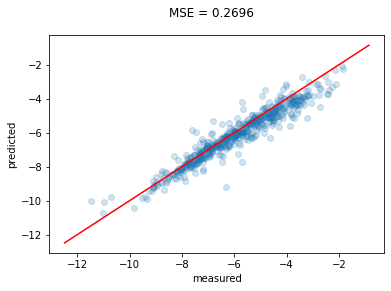

In [18]:
# 0.2696 50 epoch
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)
plt.show()

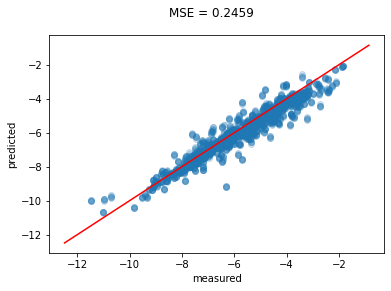

In [19]:
# 0.2459 50 epoch
# rotations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats)
plt.savefig(fig_folder + data_name + "_spherical_test.pdf")

Initialised MolLoader with 546 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=81, mode=cartesian, shuffle=False, rotate=False, device=cuda


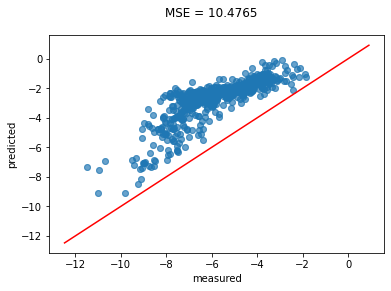

In [20]:
# rotations
seed_everything()
ml_wrong_mode_pred = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode="cartesian")
ys, y_hats = predict_epochs(net, ml_wrong_mode_pred, epochs=5)
plot_predictions(ys, y_hats)
plt.show()